In [1]:
from tdi import *

In [2]:
folder = "..\\Data\\Longitudinal_Field"
fileName = "ZCur"

SIF_REF_DATA = get_sif(folder, fileName, 0.08,1) 
CONTOURS, BINARIZE_MASK , SMOOTH_MASK_NORMED = get_contours(SIF_REF_DATA)

srf, srp, A1, A2, X1, X2 = get_splitting_ratio(SIF_REF_DATA, CONTOURS, BINARIZE_MASK )
trans1 , trans2 = srp/(srp+1), 1/(srp+1)
trans = [trans1, trans2]
AFref = [A1, A2]
Xref = [X1, X2]
θp = [np.deg2rad(3.538), np.deg2rad(3.801)]

zCurArr = np.arange(-0.1, 0.15+0.01, 0.01)
longData = np.array([[get_values(get_sif(folder, fileName, cur, r+1), trans, θp, CONTOURS, BINARIZE_MASK, AFref, Xref) for r in range(5)] for cur in zCurArr])

In [90]:
zCurArr = np.arange(-0.1, 0.15+0.01, 0.01)

Nz = 88
Rz = 0.455/2
Zcoil_GpA = (np.power(4/5, 3/2)*4*np.pi*(10**-7)*Nz/Rz)/(10**-4)

Nx = 88
Rx = 0.405/2
Xcoil_GpA = (np.power(4/5, 3/2)*4*np.pi*(10**-7)*Nx/Rx)/(10**-4)

def dI2ang(dI, θp=np.deg2rad(3.6)):
    sign = np.sign((dI + np.sin(2*θp)**2))
    return 2*θp - np.arcsin(sign*np.sqrt(np.abs((dI + np.sin(2*θp)**2))))

xdata = (zCurArr-0.025)*Zcoil_GpA
ydata = dI2ang(longData[:,:,2])-dI2ang(longData[:,:,1])
m_ydata = np.nanmean(ydata, axis = 1)
s_ydata = np.nanstd(ydata, axis =1)

In [96]:
from scipy.interpolate import splrep, BSpline

(array([-0.43476656, -0.43476656, -0.43476656, -0.43476656, -0.19129728,
        -0.08695331,  0.01739066,  0.22607861,  0.43476656,  0.43476656,
         0.43476656,  0.43476656]),
 array([ 0.22222296,  0.4302986 ,  0.58148739,  0.42903671, -0.29555315,
        -0.73814873, -0.38372967, -0.28752695,  0.        ,  0.        ,
         0.        ,  0.        ]),
 3)

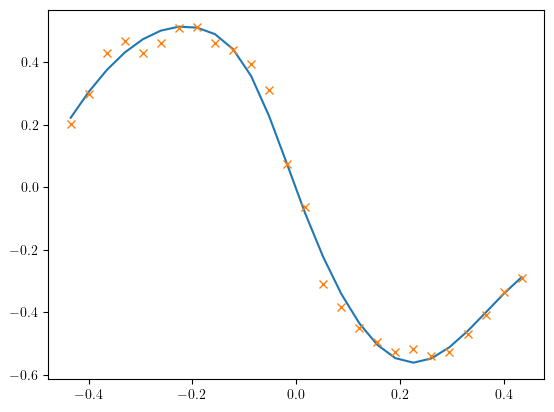

In [121]:
spl = splrep(xdata, m_ydata, s=0.03)
splModel = BSpline(*spl)
plt.plot(xdata, splModel(xdata))
plt.plot(xdata, m_ydata, 'x')
spl

array([ 6.37362962e-04, -4.14904411e+00, -1.91093496e-01,  4.18618641e+01,
        1.42963838e+00, -1.30441662e+02])

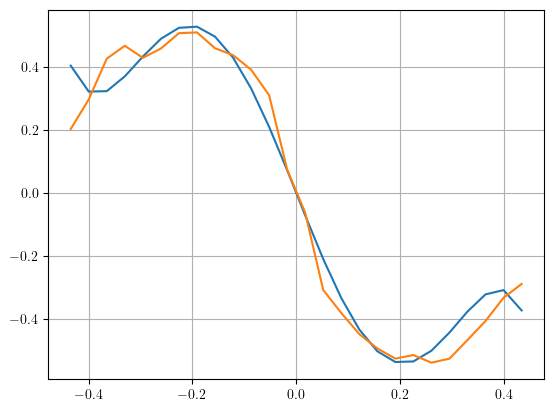

In [91]:
from scipy.optimize import curve_fit

def model(x, x0, γ):
    den1 = ((x0**2)-(x**2))**2
    den2 = (γ**2) *(x**2)
    den = den1 + den2
    renum = (x0**2)-(x**2)
    imnum = - γ * x
    return imnum/den

def poly_model(x, a0 , a1, a2, a3, a4, a5):
    return a0 + a1*x + a2*(x**2) + a3*(x**3) + a4*(x**4) + a5*(x**5)

#xArr = np.linspace(-5,5, 100)
#yArr = model(xArr, 10, 50)

popt, pcov = curve_fit(poly_model, xdata, m_ydata, sigma=s_ydata, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
plt.plot(xdata, poly_model(xdata, *popt))
plt.plot(xdata, m_ydata)

plt.grid()
popt

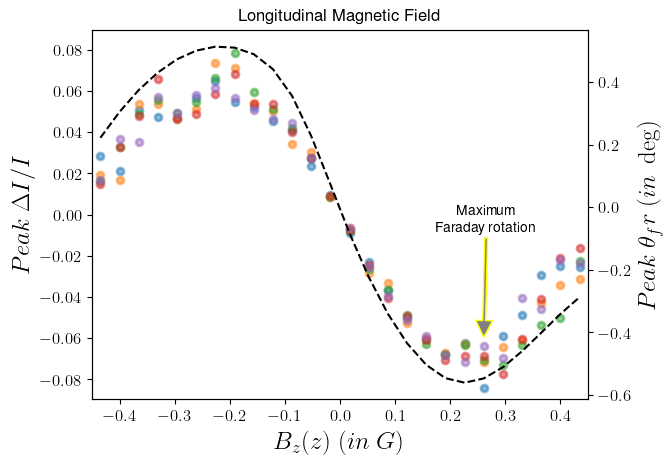

In [122]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


θfr1 = dI2ang(np.nanmean(longData[:,:,1], axis=1), θp=np.deg2rad(3.538))
θfr2 = dI2ang(np.nanmean(longData[:,:,2], axis=1), θp=np.deg2rad(3.801))
θfr = np.rad2deg((θfr2-θfr1)/2)
msfr = np.nanmean(longData[:,:,1], axis=1)
esfr = np.nanstd(longData[:,:,1], axis=1)
mfr = np.nanmean(longData[:,:,0], axis=1)
efr = np.nanstd(longData[:,:,0], axis=1)
m1fr = np.nanmedian(longData[:,:,1], axis=1)
e1fr = np.nanstd(longData[:,:,1], axis=1)
m2fr = np.nanmedian(longData[:,:,2], axis=1)
e2fr = np.nanstd(longData[:,:,2], axis=1)
#plt.errorbar(zCurArr, m1fr, e1fr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar(zCurArr, m2fr, e2fr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar((zCurArr-0.025)*GpA, m2fr-m1fr, np.sqrt(e2fr**2+e1fr**2), fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar(zCurArr, mfr, efr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.boxplot(np.transpose(longData[:,:,1]), notch=True)
#plt.gca().twinx().errorbar(zCurArr, msfr, esfr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3, c="C3")
plt.plot(xdata, (longData[:,:,1]-longData[:,:,2])/2, 'o', alpha=0.5, ms=5, mew=2)
#plt.plot((zCurArr-0.025)*GpA, np.nanmean((longData[:,:,1]-longData[:,:,2])/2, axis=1), '-', c='gray', alpha=0.5)
plt.xlim(-0.45,0.45)
#plt.grid()
plt.xlabel("$ B_z(z)  \ (in \ G)$", fontsize=18)
plt.ylabel("$ Peak \ $" + "$\\Delta I /I$", fontsize=18)
plt.annotate('Maximum \\newline  Faraday rotation', xy=((0.1-0.025)*Zcoil_GpA, -0.06), xytext=(0.175, 0.0),
            arrowprops=dict(facecolor='gray', ec='yellow' ,shrink=0.01, width=2))
plt.tick_params(axis='both', labelsize=12)
plt.title("Longitudinal Magnetic Field")
ym1 = np.max(np.abs(np.nanmean((longData[:,:,1]-longData[:,:,2])/2, axis=1)))
plt.ylim(-1.25*ym1, 1.25*ym1)
#plt.gca().twinx().plot(xdata, poly_model(xdata, *popt), 'k--')
plt.gca().twinx().plot(xdata, splModel(xdata), 'k--')
#plt.gca().twinx().plot(xdata, θfr, ".--", alpha=0.5)
plt.tick_params(axis='both', labelsize=12)
plt.ylabel("$ Peak \ $"+"$\\theta_fr \ (in \ \deg)$", fontsize=18)
#ym2 = np.max(np.abs(θfr))
#plt.ylim(-1.25*ym2, 1.25*ym2)
plt.show()

In [123]:
def proj_m(Bx):
    return splModel(np.sqrt(0.25**2+Bx**2))*0.25/np.sqrt(0.25**2+Bx**2)

"""
def proj_u(Bx):
    pu = popt + perr
    return splModel(np.sqrt(0.25**2+Bx**2))*0.25/np.sqrt(0.25**2+Bx**2)

def proj_d(Bx):
    pd = popt - perr
    return poly_model(np.sqrt(0.25**2+Bx**2),*pd)*0.25/np.sqrt(0.25**2+Bx**2)

BxA = np.linspace(-0.5, 0.5, 50)
plt.plot(BxA, proj_u(BxA))
plt.plot(BxA, proj_m(BxA))
plt.plot(BxA, proj_d(BxA))
"""

'\ndef proj_u(Bx):\n    pu = popt + perr\n    return splModel(np.sqrt(0.25**2+Bx**2))*0.25/np.sqrt(0.25**2+Bx**2)\n\ndef proj_d(Bx):\n    pd = popt - perr\n    return poly_model(np.sqrt(0.25**2+Bx**2),*pd)*0.25/np.sqrt(0.25**2+Bx**2)\n\nBxA = np.linspace(-0.5, 0.5, 50)\nplt.plot(BxA, proj_u(BxA))\nplt.plot(BxA, proj_m(BxA))\nplt.plot(BxA, proj_d(BxA))\n'

In [32]:
folder = "..\\Data\\Transverse_Field"
fileName = "Xcur"

SIF_REF_DATA = get_sif(folder, fileName, 0.05,3) 
CONTOURS, BINARIZE_MASK , SMOOTH_MASK_NORMED = get_contours(SIF_REF_DATA)

srf, srp, A1, A2, X1, X2 = get_splitting_ratio(SIF_REF_DATA, CONTOURS, BINARIZE_MASK )
trans1 , trans2 = srp/(srp+1), 1/(srp+1)
trans = [trans1, trans2]
AFref = [A1, A2]
Xref = [X1, X2]
θp = [np.deg2rad(3.538), np.deg2rad(3.801)]

xCurArr = np.arange(-0.02, 0.1, 0.01)
transData = np.array([[get_values(get_sif(folder, fileName, cur, r+1), trans, θp, CONTOURS, BINARIZE_MASK, AFref, Xref) for r in range(5)] for cur in xCurArr])

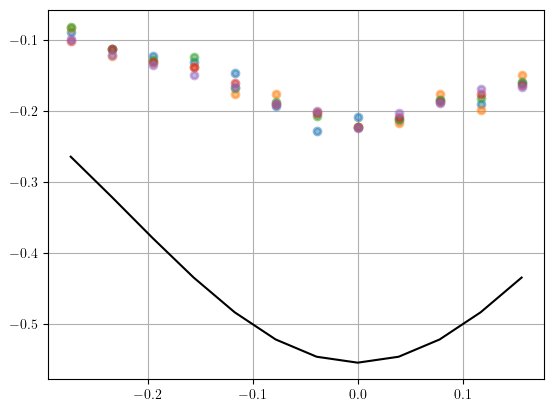

In [134]:
xCurArr = np.arange(-0.02, 0.1, 0.01)
m3fr = np.nanmean(transData[:,:,3], axis=1)
e3fr = np.nanstd(transData[:,:,3], axis=1)
m4fr = np.nanmean(transData[:,:,4], axis=1)
e4fr = np.nanstd(transData[:,:,4], axis=1)

msfr = np.nanmean(transData[:,:,1], axis=1)

txdata = (xCurArr-0.05)*Xcoil_GpA
transdI = (transData[:,:,2]-transData[:,:,1])/2


plt.plot(txdata, proj_m(txdata), 'k')
#plt.fill_between(x= txdata, y1=proj_u(txdata), y2=proj_d(txdata), color='gray', alpha=0.3)
plt.plot(txdata, dI2ang(transdI), 'o', alpha=0.5, ms=5, mew=2)
#plt.gca().twinx().errorbar((xCurArr-0.05)*Xcoil_GpA, m3fr, e3fr, fmt="ko--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar((xCurArr-0.05)*Xcoil_GpA, m4fr, e4fr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar(zCurArr, m2fr, e2fr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.errorbar(zCurArr, mfr, efr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3)
#plt.gca().twinx().errorbar(zCurArr, msfr, esfr, fmt="o--", mfc="None", capsize=2, lw=0.5, ms=3, c="C3")
#plt.boxplot(np.transpose(transData[:,:,0]), notch=True)
plt.grid()
plt.show()